# Project 3 — Luleå Christmas Tree Impact Modelling (SSP2-4.5)

Can Christmas tree farming in Luleå still work up to year 2100 under climate change?

## Objective & Scope

We assess whether Christmas trees in **Luleå** can still reach **1.5 m** in approximately **6 years** under **SSP2-4.5 (ssp245)** up to **2100**.

* **Drivers / indicators:** temperature, degree-days (temperature sum), growing-season proxy (growing weeks).
* **Model output:** time-to-harvest (years to reach 1.5 m).
* **Vulnerability rule:** a decade is considered vulnerable if the **median** time-to-harvest exceeds **10 years**.
* **Uncertainty shown:** interannual climate variability (within SSP245) + parameter sensitivity (±10% on calibrated growth scale).
* **Scenario uncertainty:**  (other SSPs), structural model uncertainty (DH formulation details), socio-economic demand changes.


In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

OUTPUTS = Path("outputs")
FIG = OUTPUTS / "figures"
TAB = OUTPUTS / "tables"
FIG.mkdir(parents=True, exist_ok=True)
TAB.mkdir(parents=True, exist_ok=True)

In [40]:
#Load data (SSP245 only) and quick check
print("Unique locations:", raw245["Location"].unique())
print("n locations:", raw245["Location"].nunique())
print("Year range:", raw245["Year"].min(), "-", raw245["Year"].max())
raw245.head()

Unique locations: ['Härnösand' 'Luleå' 'Malmö']
n locations: 3
Year range: 2015 - 2100


,Unnamed: 0,X.1,X,Lat,Lon,Year,Week,W,Temp,Location,Cpool
0,4559,4559,4559,62.630282,18.028545,2015,1,0.620269,-11.353929,Härnösand,1.009127
1,4560,4560,4560,62.630282,18.028545,2015,2,0.526487,-8.434957,Härnösand,1.036823
2,4561,4561,4561,62.630282,18.028545,2015,3,0.516709,-1.093414,Härnösand,1.001133
3,4562,4562,4562,62.630282,18.028545,2015,4,0.538442,-9.629086,Härnösand,0.938878
4,4563,4563,4563,62.630282,18.028545,2015,5,0.493136,-4.284000,Härnösand,0.871603


In [42]:
def filter_location(df, wanted=("Luleå","Lulea","Luleaa")):
    out = df[df["Location"].isin(wanted)].copy()
    if out.empty:
        out = df[df["Location"].astype(str).str.lower().str.contains("lule")].copy()
    return out

l245 = filter_location(raw245)

print("Rows in Luleå (ssp245):", len(l245))
print("Locations kept:", l245["Location"].unique())
l245.head()

Rows in Luleå (ssp245): 4558
Locations kept: ['Luleå']


,Unnamed: 0,X.1,X,Lat,Lon,Year,Week,W,Temp,Location,Cpool
53,9117,9117,9117,65.621823,21.95548,2015,1,0.914534,-14.776029,Luleå,1.009127
54,9118,9118,9118,65.621823,21.95548,2015,2,0.893549,-15.382171,Luleå,1.036823
55,9119,9119,9119,65.621823,21.95548,2015,3,0.877240,-6.528257,Luleå,1.001133
56,9120,9120,9120,65.621823,21.95548,2015,4,0.867597,-9.234229,Luleå,0.938878
57,9121,9121,9121,65.621823,21.95548,2015,5,0.876409,-5.982771,Luleå,0.871603


Time axis + Kelvin→Celsius

In [44]:
def add_week_time(df, year_col="Year", week_col="Week"):
    """
    Create datetime from ISO year + ISO week (Monday of each ISO week).
    Works for weekly climate data.
    """
    out = df.copy()
    iso = (
        out[year_col].astype(int).astype(str)
        + "-W"
        + out[week_col].astype(int).astype(str).str.zfill(2)
        + "-1"
    )
    out["time"] = pd.to_datetime(iso, format="%G-W%V-%u")
    out = out.sort_values("time").reset_index(drop=True)
    return out

def to_celsius_if_needed(df, temp_col="Temp"):
    out = df.copy()
    t = out[temp_col].astype(float)
    # Kelvin check (rough but safe)
    if np.nanmedian(t) > 100:
        t = t - 273.15
    out["temp_c"] = t
    return out

l245 = add_week_time(l245)
l245 = to_celsius_if_needed(l245, "Temp")

print("Date range:", l245["time"].min(), "→", l245["time"].max())
print("Temp (°C) range:", float(l245["temp_c"].min()), "→", float(l245["temp_c"].max()))
print("Median time step (days):", np.median(np.diff(l245["time"]).astype("timedelta64[D]").astype(int)))

l245[["time","Year","Week","temp_c","Location"]].head()


Date range: 2014-12-29 00:00:00 → 2101-01-03 00:00:00
Temp (°C) range: -33.3386142857143 → 22.7284285714286
Median time step (days): 7.0


,time,Year,Week,temp_c,Location
0,2014-12-29,2015,1,-14.776029,Luleå
1,2015-01-05,2015,2,-15.382171,Luleå
2,2015-01-12,2015,3,-6.528257,Luleå
3,2015-01-19,2015,4,-9.234229,Luleå
4,2015-01-26,2015,5,-5.982771,Luleå


Annual mean temperature - temperature trend that supports DH “Driver” narrative.

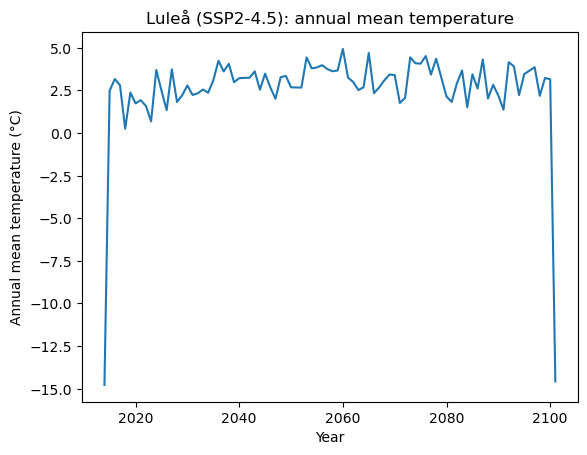

In [46]:
l245["year"] = l245["time"].dt.year
annual_temp = l245.groupby("year", as_index=False)["temp_c"].mean()

plt.figure()
plt.plot(annual_temp["year"], annual_temp["temp_c"])
plt.xlabel("Year")
plt.ylabel("Annual mean temperature (°C)")
plt.title("Luleå (SSP2-4.5): annual mean temperature")
plt.show()

Key indicators: degree-days + growing weeks (variables)

In [47]:
BASE_TEMP = 5.0
DAYS_PER_STEP = 7  # weekly data

l245["dd_week"] = np.maximum(l245["temp_c"] - BASE_TEMP, 0.0) * DAYS_PER_STEP
l245["growing_week"] = (l245["temp_c"] > BASE_TEMP).astype(int)

annual_ind = l245.groupby("year", as_index=False).agg(
    tmean=("temp_c", "mean"),
    dd_sum=("dd_week", "sum"),
    growing_weeks=("growing_week", "sum")
)

# Drop incomplete / zero-growth years (fixes 2014 issue)
annual_ind = annual_ind[annual_ind["dd_sum"] > 0].copy()

annual_ind.head()

,year,tmean,dd_sum,growing_weeks
1,2015,2.472488,1019.7075,23
2,2016,3.164999,1153.8100,22
3,2017,2.797495,1161.3551,21
4,2018,0.249637,910.4948,20
5,2019,2.369700,1180.7754,24


In [49]:
annual_ind.to_csv(TAB / "annual_indicators_lulea_ssp245.csv", index=False)

Simple growth/harvest model + calibration - parameterisation and baseline (1.5m in 6y).

In [51]:
TARGET_HEIGHT = 1.5
BASELINE_YEARS = 6.0

min_year = int(annual_ind["year"].min())
max_year = int(annual_ind["year"].max())
ref_start = min_year
ref_end = min(min_year + 14, max_year)  # first 15 years

def calibrate_k_auto(annual_ind, baseline_years=BASELINE_YEARS, ref_start=ref_start, ref_end=ref_end):
    ref = annual_ind[(annual_ind["year"] >= ref_start) & (annual_ind["year"] <= ref_end)].dropna(subset=["dd_sum"])
    dd_ref = float(np.median(ref["dd_sum"].values))
    if dd_ref <= 0:
        raise ValueError("Calibration dd_sum is non-positive; check BASE_TEMP and preprocessing.")
    k = TARGET_HEIGHT / (baseline_years * dd_ref)
    return k, dd_ref

k, dd_ref = calibrate_k_auto(annual_ind, baseline_years=BASELINE_YEARS, ref_start=ref_start, ref_end=ref_end)

print("Calibration period:", ref_start, "→", ref_end)
print("Median dd_sum in calibration period:", dd_ref)
print("Calibrated k:", k)


Calibration period: 2015 → 2029
Median dd_sum in calibration period: 1152.7138999999993
Calibrated k: 0.00021687948761613801


Time-to-harvest + vulnerability

In [52]:
annual_ind["annual_growth_m_per_yr"] = np.maximum(k * annual_ind["dd_sum"], 1e-9)
annual_ind["tth_years"] = TARGET_HEIGHT / annual_ind["annual_growth_m_per_yr"]

VULN_TTH = 10.0
annual_ind["vulnerable_year"] = annual_ind["tth_years"] > VULN_TTH

annual_ind.to_csv(TAB / "annual_time_to_harvest_lulea_ssp245.csv", index=False)
annual_ind.head()

,year,tmean,dd_sum,growing_weeks,annual_growth_m_per_yr,tth_years,vulnerable_year
1,2015,2.472488,1019.7075,23,0.221154,6.782615,False
2,2016,3.164999,1153.8100,22,0.250238,5.994300,False
3,2017,2.797495,1161.3551,21,0.251874,5.955356,False
4,2018,0.249637,910.4948,20,0.197468,7.596181,False
5,2019,2.369700,1180.7754,24,0.256086,5.857408,False


In [60]:
# Sanity check: median TTH in calibration period should be close to BASELINE_YEARS
calib_mask = (annual_ind["year"] >= ref_start) & (annual_ind["year"] <= ref_end)
print("Median TTH in calibration period:", float(np.median(annual_ind.loc[calib_mask, "tth_years"])))
print("Baseline years target:", BASELINE_YEARS)


Median TTH in calibration period: 6.0
Baseline years target: 6.0


Decadal vulnerability

In [53]:
annual_ind["decade"] = (annual_ind["year"] // 10) * 10

dec = annual_ind.groupby("decade")["tth_years"].agg(
    median="median",
    p10=lambda x: np.quantile(x, 0.10),
    p90=lambda x: np.quantile(x, 0.90),
).reset_index()

dec["vulnerable_decade"] = dec["median"] > VULN_TTH
dec.to_csv(TAB / "decadal_vulnerability_lulea_ssp245.csv", index=False)

dec

,decade,median,p10,p90,vulnerable_decade
0,2010,5.994300,5.896587,7.270755,False
1,2020,6.044066,5.374173,7.138028,False
2,2030,6.066238,5.458103,6.271173,False
3,2040,5.772151,5.098245,6.331668,False
4,2050,5.343467,4.995223,6.443338,False
5,2060,5.729484,4.997532,6.468102,False
6,2070,5.258663,4.717113,5.973417,False
7,2080,5.334049,5.144352,6.080280,False
8,2090,5.492861,5.109590,6.544837,False
9,2100,5.075866,5.075866,5.075866,False


Uncertainty analysis (climate variability + parameter sensitivity) - Error bars

In [54]:
def tth_with_k(annual_ind, k_value):
    out = annual_ind[["year","dd_sum"]].copy()
    out["decade"] = (out["year"] // 10) * 10
    growth = np.maximum(k_value * out["dd_sum"].values, 1e-9)
    out["tth_years"] = TARGET_HEIGHT / growth
    return out

k_factors = [0.9, 1.0, 1.1]
all_runs = pd.concat(
    [tth_with_k(annual_ind, k*f).assign(k_factor=f) for f in k_factors],
    ignore_index=True
)

dec_u = all_runs.groupby("decade")["tth_years"].agg(
    median="median",
    p10=lambda x: np.quantile(x, 0.10),
    p90=lambda x: np.quantile(x, 0.90),
).reset_index()

dec_u["vulnerable_decade"] = dec_u["median"] > VULN_TTH
dec_u.to_csv(TAB / "decadal_uncertainty_lulea_ssp245.csv", index=False)

dec_u

,decade,median,p10,p90,vulnerable_decade
0,2010,6.508231,5.428122,7.572204,False
1,2020,6.111799,5.132544,7.624577,False
2,2030,5.951271,5.046914,6.831014,False
3,2040,5.703824,4.965744,6.794381,False
4,2050,5.517530,4.695697,6.443338,False
5,2060,5.729484,4.621419,6.570785,False
6,2070,5.290527,4.657483,6.278526,False
7,2080,5.467674,4.779360,6.606975,False
8,2090,5.615143,4.851490,6.544837,False
9,2100,5.075866,4.706712,5.527054,False


Plots

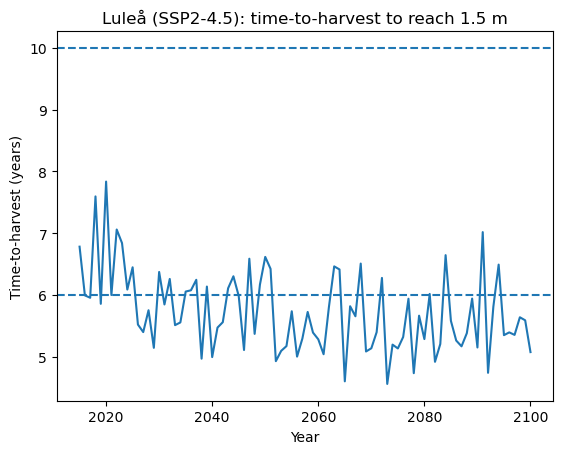

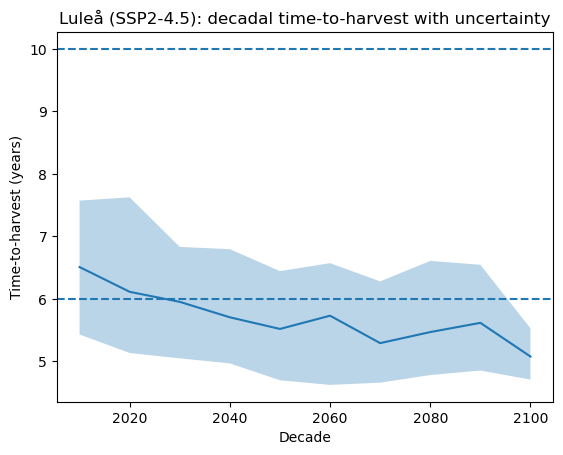

In [55]:
plt.figure()
plt.plot(annual_ind["year"], annual_ind["tth_years"])
plt.axhline(BASELINE_YEARS, linestyle="--")
plt.axhline(VULN_TTH, linestyle="--")
plt.xlabel("Year")
plt.ylabel("Time-to-harvest (years)")
plt.title("Luleå (SSP2-4.5): time-to-harvest to reach 1.5 m")
plt.savefig(FIG / "lulea_tth_annual_ssp245.png", dpi=200, bbox_inches="tight")
plt.show()

plt.figure()
plt.plot(dec_u["decade"], dec_u["median"])
plt.fill_between(dec_u["decade"], dec_u["p10"], dec_u["p90"], alpha=0.3)
plt.axhline(BASELINE_YEARS, linestyle="--")
plt.axhline(VULN_TTH, linestyle="--")
plt.xlabel("Decade")
plt.ylabel("Time-to-harvest (years)")
plt.title("Luleå (SSP2-4.5): decadal time-to-harvest with uncertainty")
plt.savefig(FIG / "lulea_tth_decadal_uncertainty_ssp245.png", dpi=200, bbox_inches="tight")
plt.show()

------------IGNORE BELOW----------------

In [59]:
print("temp_c stats:", l245["temp_c"].describe())
print("dd_week stats:", l245["dd_week"].describe())

# How many weeks are above BASE_TEMP?
print("Weeks above BASE_TEMP:", int((l245["temp_c"] > BASE_TEMP).sum()), "out of", len(l245))

# Check annual dd_sum distribution
print(annual_ind[["year","dd_sum","growing_weeks"]].head(10))
print(annual_ind[["dd_sum","growing_weeks"]].describe())


temp_c stats: count    4558.000000
mean        2.974556
std         9.830413
min       -33.338614
25%        -4.556457
50%         2.338279
75%        11.966775
max        22.728429
Name: temp_c, dtype: float64
dd_week stats: count    4558.000000
mean       23.025346
std        31.830363
min         0.000000
25%         0.000000
50%         0.000000
75%        48.767425
max       124.099000
Name: dd_week, dtype: float64
Weeks above BASE_TEMP: 2003 out of 4558
    year     dd_sum  growing_weeks
1   2015  1019.7075             23
2   2016  1153.8100             22
3   2017  1161.3551             21
4   2018   910.4948             20
5   2019  1180.7754             24
6   2020   882.5822             22
7   2021  1152.7139             23
8   2022   979.5840             22
9   2023  1011.0143             21
10  2024  1136.0270             25
            dd_sum  growing_weeks
count    86.000000      86.000000
mean   1220.343359      23.290698
std     133.345946       1.651141
min     882.582

In [12]:
# Pick a calibration period that exists in dataset
min_year = int(annual_ind["year"].min())
max_year = int(annual_ind["year"].max())

# Use first 15 years 
ref_start = min_year
ref_end = min(min_year + 14, max_year)

print("Available years:", min_year, "→", max_year)
print("Using calibration period:", ref_start, "→", ref_end)

def calibrate_k_auto(annual_ind, baseline_years=6.0, ref_start=ref_start, ref_end=ref_end):
    ref = annual_ind[(annual_ind["year"] >= ref_start) & (annual_ind["year"] <= ref_end)].dropna(subset=["dd_sum"])
    if ref.empty:
        raise ValueError("No rows in chosen calibration period.")
    dd_ref = float(np.median(ref["dd_sum"].values))
    if dd_ref <= 0:
        raise ValueError(f"Calibration dd_sum median is {dd_ref}. Try lowering BASE_TEMP or check dd_sum.")
    k = TARGET_HEIGHT / (baseline_years * dd_ref)
    return k, dd_ref

k, dd_ref = calibrate_k_auto(annual_ind, baseline_years=BASELINE_YEARS, ref_start=ref_start, ref_end=ref_end)
print("Calibrated k:", k)
print("Median dd_sum in calibration period:", dd_ref)


Available years: 2014 → 2101
Using calibration period: 2014 → 2028
Calibrated k: 0.0015404563447875797
Median dd_sum in calibration period: 162.28957142857143
